# im2latex: Data Binning

&copy; Copyright 2017 - 2018 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

----
## 'Binning' Training Data by Markup Sequence Length
Next, we'll group the samples by length of the (tokenized) latex formulas. The idea is to standardize the sequence lengths to a small set of fixed lengths (by padding smaller neighboring sequences with a 'null' tokens at the end.). This will allow us to create equal length batches for RNN/LSTM training while minimizing wasted training cycles. The [Show, Attend and Tell paper](https://www.semanticscholar.org/paper/Show-Attend-and-Tell-Neural-Image-Caption-Generati-Xu-Ba/146f6f6ed688c905fb6e346ad02332efd5464616) suggests this approach. At every epoch, we'll randomly/uniformly draw batches from within each group. Then we'll randomize said batch-list and use it for the training epoch. At next epoch, we'll repeat the process. The larger our group-size, that much better randomness we'll get in the training sequence. However the downside of increasing group-size is more padding of sequence-lengths resulting in wasteful  (and worse; maybe even misleading) training cycles.

-----

In [1]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160

### Notebook Arguments
Change the arguments below before you run the notebook.

In [3]:
HYPER_batch_size = 56
data_folder = data_dir = '../data/dataset5'
image_folder = image_dir = os.path.join(data_folder, 'formula_images')
raw_data_dir = os.path.join(data_folder, 'training_56')
input_data_dir = os.path.join(data_folder, 'step4')
dump = False

In [4]:
print('Output Dir = %s'%raw_data_dir)

Output Dir = ../data/dataset5/training_56


In [5]:
df_train = pd.read_pickle(os.path.join(input_data_dir, 'df_train.pkl'))
print('df_train.shape = %s'%(df_train.shape,))
df_valid = pd.read_pickle(os.path.join(input_data_dir, 'df_valid.pkl'))
print('df_valid.shape = %s'%(df_valid.shape,))
df_test = pd.read_pickle(os.path.join(input_data_dir, 'df_test.pkl'))
print('df_test.shape = %s'%(df_test.shape,))

df_train.shape = (114406, 7)
df_valid.shape = (14280, 7)
df_test.shape = (14280, 7)


In [6]:
def round_up(df_, batch_size):
    # round df_ up to an integral multiple of batch_size by duplicating randomly selected samples
    remainder =  - df_.shape[0]%batch_size
    if remainder > 0:
        shortfall = batch_size - remainder
        print('Rounding up df_ from size %d to %d'%(df_.shape[0], df_.shape[0]+shortfall))
        df_shortfall = df_.sample(n=shortfall)
        df_shortfall.index = (df_shortfall.index + 1000000) # Add 1 mil to the index to ensure unique index
        df_ = df_.append(df_shortfall, verify_integrity=True)
    assert df_.index.intersection(df_test.index).shape[0] == 0
    return df_

In [8]:
# round df_train up to an integral multiple of batch_size by duplicating randomly selected samples
original_shape = df_train.shape
print(original_shape)
df_train = round_up(df_train, HYPER_batch_size)
print(df_test.shape, df_valid.shape, df_train.shape)
print('Rounded up samples = %d, Actual samples = %d'%(df_test.shape[0]+df_train.shape[0]+df_valid.shape[0], 
                                                      original_shape[0]+df_test.shape[0]+df_valid.shape[0],
                                                     ))

(114460, 7)
Rounding up df_ from size 114460 to 114512
(14280, 7) (14280, 7) (114512, 7)
Rounded up samples = 143072, Actual samples = 143020


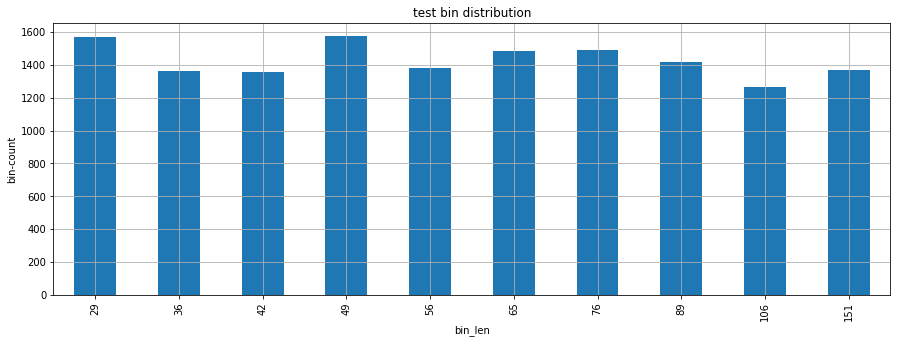

In [9]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('test bin distribution')
df_test.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

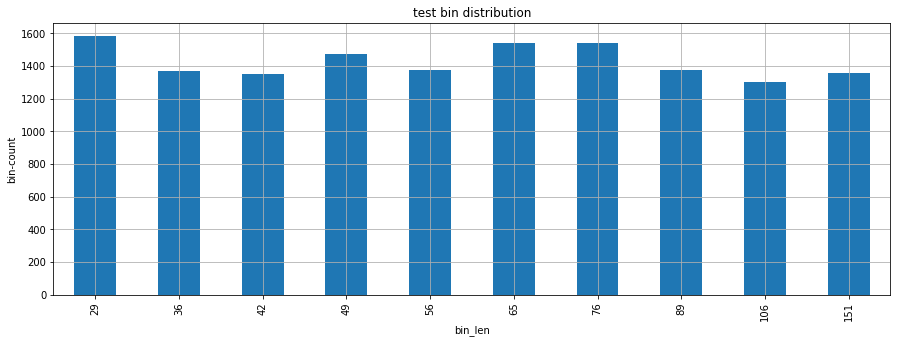

In [10]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('test bin distribution')
df_valid.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

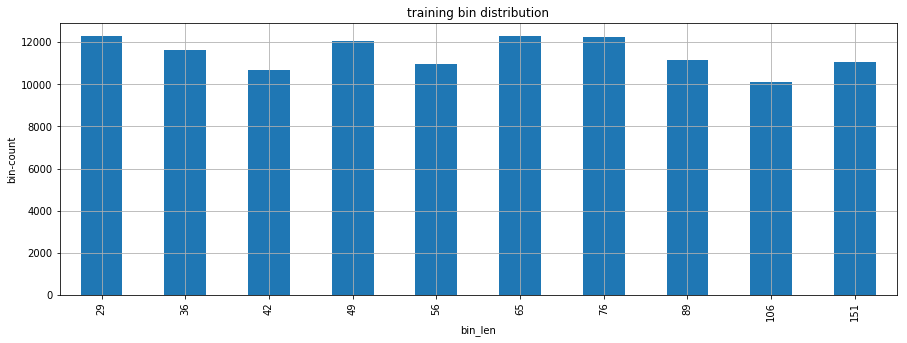

In [11]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('training bin distribution')
df_train.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [12]:
## Code that adjusts bin-composition in order to minimze waste of samples owing to batch quantization
def print_bin_waste(df_, batch_size_):
    cum = 0
    bin_lens = sorted(df_.bin_len.unique().tolist())
    counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
    total = sum(counts)
    print('bin_len|count|waste|cumulative')
    for i in range(len(bin_lens)):
        rem = counts[i] % batch_size_
        cum += rem
        print("%d)\t%d,\t%d,\t%d"%(bin_lens[i], counts[i], rem, cum))
    assert total == sum(counts)
    print('total %% batch_size_ = %d'%(total%batch_size_,))
    return

def adjust_bins(df_bins_, batch_size_):
    df_ = df_bins_.copy()
    bin_lens = bins = sorted(df_.bin_len.unique().tolist())
    for i in range(len(bin_lens)-1):
        ## Can't use bin_count here because it changes during the loop
        rem = df_[df_.bin_len == bins[i]].shape[0] % batch_size_
        if rem > 0:
            ## Move the tail of the bin into the next one
            idx_tail = df_[df_.bin_len == bins[i]].word2id_len.sort_values()[-1*rem:].index
            df_.loc[idx_tail, 'bin_len'] = bins[i+1]
            print('Moving %d samples from bin %d to %d'%(rem,bin_lens[i],bin_lens[i+1]))

    return df_

# def adjust_bins2(df_bins_, batch_size_):
#     df_ = df_bins_.copy()
#     ## Idea is to spread the sample-waste over all the bins, proportional to the size of the bin.
#     waste = df_.shape[0] % batch_size_
#     bin_lens = sorted(df_.bin_len.unique().tolist())
#     bin_counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
#     ## Draw from a multinomial distribution to get the number of samples to waste in each bin.
#     pvals = np.array(bin_counts, dtype=float) / df_.shape[0]
#     assert sum(pvals) == 1.0
#     print(pvals, " sum=%f"%(sum(pvals),))
#     bin_waste = np.random.multinomial(waste, pvals)
#     print(bin_waste, " sum=%d"%(sum(bin_waste),))
#     ## Now adjust the bins
#     for i in range(len(bin_lens)-1):
#         ## Can't use bin_count here because it changes during the loop
#         rem = df_[df_.bin_len == bin_lens[i]].shape[0] % batch_size_ - bin_waste[i]
#         if rem > 0:
#             ## Move the tail of the bin into the next one
#             df_slice = df_[df_.bin_len == bin_lens[i]].word2id_len.sort_values()[-1*rem:].index
#             df_.loc[df_slice, 'bin_len'] = bin_lens[i+1]
#             print('Moving %d samples from bin %d to %d'%(rem,bin_lens[i],bin_lens[i+1]))
#         elif rem < 0:
#             ## Move in the head of the next bin into this one
#             df_slice = df_[df_.bin_len == bin_lens[i+1]].word2id_len.sort_values()[:-1*rem].index
#             new_bin_len = df_.loc[df_slice].word2id_len.max() + 1
#             print('Moving %d samples from bin %d to %d (old_bin_len = %d)'%(rem,bin_lens[i+1],new_bin_len,bin_lens[i]))
#             df_.loc[df_slice, 'bin_len'] = new_bin_len
#             df_.loc[df_.bin_len == bin_lens[i], 'bin_len'] = new_bin_len
#             bin_lens[i] = new_bin_len
#     print('Final bins: ', bin_lens)
#     return df_

bin_len|count|waste|cumulative
29)	12290,	26,	26
36)	11615,	23,	49
42)	10670,	30,	79
49)	12072,	32,	111
56)	10944,	24,	135
65)	12301,	37,	172
76)	12261,	53,	225
89)	11179,	35,	260
106)	10118,	38,	298
151)	11062,	30,	328
total % batch_size_ = 48
Moving 26 samples from bin 29 to 36
Moving 49 samples from bin 36 to 42
Moving 23 samples from bin 42 to 49
Moving 55 samples from bin 49 to 56
Moving 23 samples from bin 56 to 65
Moving 4 samples from bin 65 to 76
Moving 1 samples from bin 76 to 89
Moving 36 samples from bin 89 to 106
Moving 18 samples from bin 106 to 151
bin_len|count|waste|cumulative
29)	12264,	0,	0
36)	11592,	0,	0
42)	10696,	0,	0
49)	12040,	0,	0
56)	10976,	0,	0
65)	12320,	0,	0
76)	12264,	0,	0
89)	11144,	0,	0
106)	10136,	0,	0
151)	11080,	48,	48
total % batch_size_ = 48


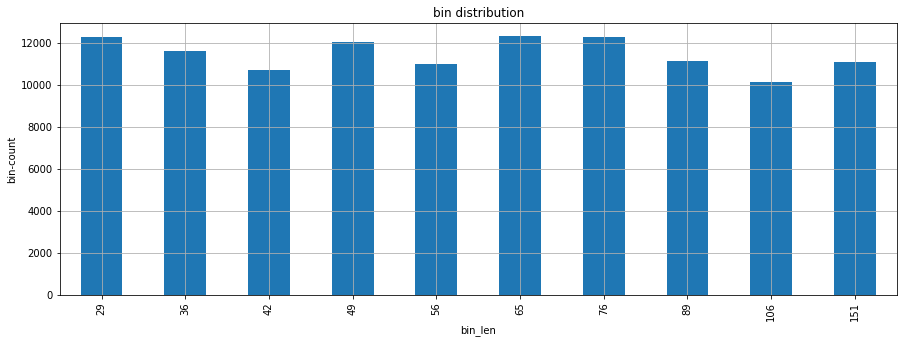

In [13]:
print_bin_waste(df_train, HYPER_batch_size)
df_train_adjusted = adjust_bins(df_train, HYPER_batch_size)
print_bin_waste(df_train_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_xlabel('bin_len')
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_train_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

bin_len|count|waste|cumulative
29)	1569,	1,	1
36)	1365,	21,	22
42)	1358,	14,	36
49)	1577,	9,	45
56)	1381,	37,	82
65)	1485,	29,	111
76)	1489,	33,	144
89)	1418,	18,	162
106)	1266,	34,	196
151)	1372,	28,	224
total % batch_size_ = 0
Moving 1 samples from bin 29 to 36
Moving 22 samples from bin 36 to 42
Moving 36 samples from bin 42 to 49
Moving 45 samples from bin 49 to 56
Moving 26 samples from bin 56 to 65
Moving 55 samples from bin 65 to 76
Moving 32 samples from bin 76 to 89
Moving 50 samples from bin 89 to 106
Moving 28 samples from bin 106 to 151
bin_len|count|waste|cumulative
29)	1568,	0,	0
36)	1344,	0,	0
42)	1344,	0,	0
49)	1568,	0,	0
56)	1400,	0,	0
65)	1456,	0,	0
76)	1512,	0,	0
89)	1400,	0,	0
106)	1288,	0,	0
151)	1400,	0,	0
total % batch_size_ = 0


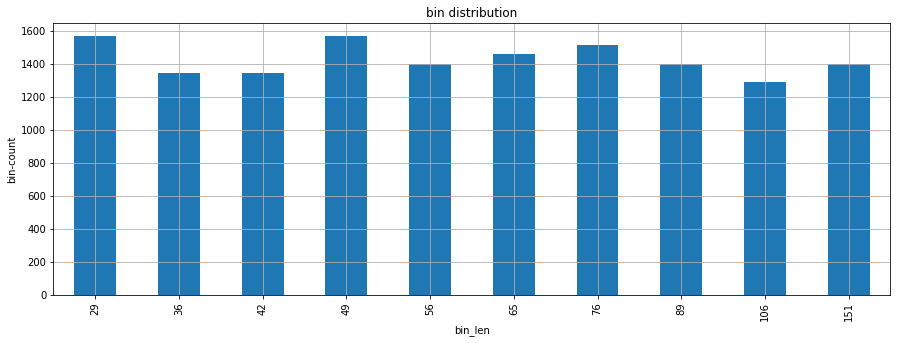

In [14]:
print_bin_waste(df_test, HYPER_batch_size)
df_test_adjusted = adjust_bins(df_test, HYPER_batch_size)
print_bin_waste(df_test_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_test_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

bin_len|count|waste|cumulative
29)	1585,	17,	17
36)	1372,	28,	45
42)	1350,	6,	51
49)	1475,	19,	70
56)	1376,	32,	102
65)	1543,	31,	133
76)	1544,	32,	165
89)	1378,	34,	199
106)	1300,	12,	211
151)	1357,	13,	224
total % batch_size_ = 0
Moving 17 samples from bin 29 to 36
Moving 45 samples from bin 36 to 42
Moving 51 samples from bin 42 to 49
Moving 14 samples from bin 49 to 56
Moving 46 samples from bin 56 to 65
Moving 21 samples from bin 65 to 76
Moving 53 samples from bin 76 to 89
Moving 31 samples from bin 89 to 106
Moving 43 samples from bin 106 to 151
bin_len|count|waste|cumulative
29)	1568,	0,	0
36)	1344,	0,	0
42)	1344,	0,	0
49)	1512,	0,	0
56)	1344,	0,	0
65)	1568,	0,	0
76)	1512,	0,	0
89)	1400,	0,	0
106)	1288,	0,	0
151)	1400,	0,	0
total % batch_size_ = 0


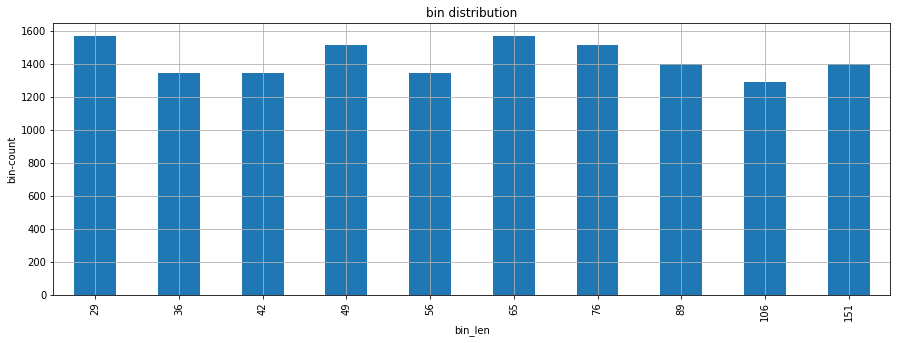

In [15]:
print_bin_waste(df_valid, HYPER_batch_size)
df_valid_adjusted = adjust_bins(df_valid, HYPER_batch_size)
print_bin_waste(df_valid_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_valid_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [16]:
def get_padded(df_):
    def pad(row_ar):
        """
        Return null-terminated and padded token-sequence, padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'word2id_len', 'word2id')
        """
        word2id = row_ar[2]
        ## plen = (pad_before, pad_after)
        plen = (0, row_ar[0]-row_ar[1])
        ## Ensure that we have room for at least one null-terminator
        assert plen[1] > 0
        return np.pad(word2id, plen, 'constant', constant_values=0).tolist()
    
    df = df_[['bin_len', 'word2id_len', 'word2id']]
    padded_seq = df.apply(pad, raw=True, reduce=True, axis=1)
    df_padded = df_.assign(seq_len=df_.word2id_len+1, ## add 1 for <eos> token (null)
                      padded_seq=padded_seq, 
                      padded_seq_len=padded_seq.str.len())
    print(df_padded.shape)
    display(df_padded[:1])
    return df_padded

#### TODO: Squashing is not needed if we do not have any whitespace token. Need to short-cut this step by simply assigning padded_seq to squashed_seq

In [17]:
def get_squashed(df_):
    def squash(row_ar):
        """
        Return padded token-sequence, with all spaces removed and padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'word2id')
        """
        word2id = np.asarray(row_ar[1])
        squashed = word2id[word2id != 556]
        return squashed.tolist()
    def pad2(row_ar):
        """
        Return null-terminated and padded token-sequence, padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'col')
        """
        lst = row_ar[1]
        ## plen = (pad_before, pad_after)
        plen = (0, row_ar[0] - len(lst))
        ## Ensure that we have room for at least one null-terminator
        try:
            assert plen[1] > 0
        except:
            print (row_ar)
            raise
        return np.pad(lst, plen, 'constant', constant_values=0).tolist()

    df = df_[['bin_len', 'word2id']]
    squashed_seq = df.apply(squash, raw=True, reduce=True, axis=1)
    df_ =  df_.assign(squashed_seq=squashed_seq,
                      squashed_len=squashed_seq.str.len()+1) ## add 1 for <eos>/null token
    ## Pad the squashed sequence. Had to do this separately since str.len() would
    ## return bin-lens if this was done in the previous step.
    df = df_[['bin_len', 'squashed_seq']]
    padded_seq = df.apply(pad2, raw=True, reduce=True, axis=1)
    df_squashed = df_.assign(squashed_seq=padded_seq)
    print(df_squashed.shape)
    display(df_squashed[:1])
    return df_squashed

In [18]:
df_train_padded = get_padded(df_train_adjusted)
assert sum(df_train_padded.padded_seq_len != df_train_padded.bin_len) == 0
assert sum(df_train_padded.word2id_len != (df_train_padded.seq_len-1)) == 0

(114512, 10)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len
0,23be72ded29e9b4_basic.png,78,738,112,151,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 336, 311, 319, 62, 195, 334, 312, 336, 304, 334, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 336, 311, 319, 62, 195, 334, 312, 336, 304, 334, 11...",151,113


In [19]:
df_train_squashed = get_squashed(df_train_padded)
assert sum(df_train_squashed.seq_len < df_train_squashed.squashed_len) == 0

(114512, 12)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
0,23be72ded29e9b4_basic.png,78,738,112,151,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 336, 311, 319, 62, 195, 334, 312, 336, 304, 334, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 336, 311, 319, 62, 195, 334, 312, 336, 304, 334, 11...",151,113,113,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 336, 311, 319, 62, 195, 334, 312, 336, 304, 334, 11..."


In [20]:
df_valid_padded = get_padded(df_valid_adjusted)
assert sum(df_valid_padded.padded_seq_len != df_valid_padded.bin_len) == 0
assert sum(df_valid_padded.word2id_len != (df_valid_padded.seq_len-1)) == 0

(14280, 10)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len
33457,a648e6268d4c973_basic.png,34,580,29,36,"[34, 6, 206, 7, 28, 19, 281, 96, 6, 281, 96, 9, 30, 9, 31, 7, 57, 57, 10, 233, 206, 28, 15, 10, ...","E ( \nu ) = 4 \upsilon \alpha ( \upsilon \alpha + A + B ) \ \ , \quad \nu = 0 , 1 , . . .","[34, 6, 206, 7, 28, 19, 281, 96, 6, 281, 96, 9, 30, 9, 31, 7, 57, 57, 10, 233, 206, 28, 15, 10, ...",36,30


In [21]:
df_valid_squashed = get_squashed(df_valid_padded)
assert sum(df_valid_squashed.seq_len < df_valid_squashed.squashed_len) == 0

(14280, 12)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
33457,a648e6268d4c973_basic.png,34,580,29,36,"[34, 6, 206, 7, 28, 19, 281, 96, 6, 281, 96, 9, 30, 9, 31, 7, 57, 57, 10, 233, 206, 28, 15, 10, ...","E ( \nu ) = 4 \upsilon \alpha ( \upsilon \alpha + A + B ) \ \ , \quad \nu = 0 , 1 , . . .","[34, 6, 206, 7, 28, 19, 281, 96, 6, 281, 96, 9, 30, 9, 31, 7, 57, 57, 10, 233, 206, 28, 15, 10, ...",36,30,30,"[34, 6, 206, 7, 28, 19, 281, 96, 6, 281, 96, 9, 30, 9, 31, 7, 57, 57, 10, 233, 206, 28, 15, 10, ..."


In [22]:
df_test_padded = get_padded(df_test_adjusted)
assert sum(df_test_padded.padded_seq_len != df_test_padded.bin_len) == 0
assert sum(df_test_padded.word2id_len != (df_test_padded.seq_len-1)) == 0

(14280, 10)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len
63251,a85bc599a20418d_basic.png,67,312,34,36,"[145, 305, 334, 333, 336, 28, 11, 212, 334, 319, 321, 336, 334, 150, 334, 145, 336, 334, 200, 33...",\epsilon _ { z } = - \operatorname { l n } { \frac { \epsilon } { \mu } } + \sigma ( r _ { h } )...,"[145, 305, 334, 333, 336, 28, 11, 212, 334, 319, 321, 336, 334, 150, 334, 145, 336, 334, 200, 33...",36,35


In [23]:
df_test_squashed = get_squashed(df_test_padded)
assert sum(df_test_squashed.seq_len < df_test_squashed.squashed_len) == 0

(14280, 12)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
63251,a85bc599a20418d_basic.png,67,312,34,36,"[145, 305, 334, 333, 336, 28, 11, 212, 334, 319, 321, 336, 334, 150, 334, 145, 336, 334, 200, 33...",\epsilon _ { z } = - \operatorname { l n } { \frac { \epsilon } { \mu } } + \sigma ( r _ { h } )...,"[145, 305, 334, 333, 336, 28, 11, 212, 334, 319, 321, 336, 334, 150, 334, 145, 336, 334, 200, 33...",36,35,35,"[145, 305, 334, 333, 336, 28, 11, 212, 334, 319, 321, 336, 334, 150, 334, 145, 336, 334, 200, 33..."


In [24]:
df_train_squashed.seq_len[df_train_padded.bin_len == 36].values.shape
## (6144,)

(11592,)

In [25]:
# Since we do not have a whitespace token the squashed and sequence lengths should be the same
# In an earlier revision of the code we had whitespace tokens - necessitating squashing which is not needed anymore
# but the code is still there, therefore the following assert just ensures that the code is doing the right thing
assert df_train_squashed.seq_len.equals(df_train_squashed.squashed_len)
assert df_test_squashed.seq_len.equals(df_test_squashed.squashed_len)
assert df_valid_squashed.seq_len.equals(df_valid_squashed.squashed_len)

In [26]:
def make_seq_bins(df_):
    """
    Creates ndarrays of (padded) sequence bins from df_*_padded 
    and pickles them as a dictionary of ndarrays wrapped in dataframes.
    This preprocessing is needed in order to quickly obtain an ndarray of
    token-sequences at training time.
    """
    bin_lens = df_.bin_len.unique()
    bins = {}
    bins_squashed = {}
    
    for len_ in bin_lens:
        df_slice = df_[df_.padded_seq_len == len_]
        bin_ = np.array(df_slice.padded_seq.values.tolist(), dtype=np.int32)
        bin_squashed = np.array(df_slice.squashed_seq.values.tolist(), dtype=np.int32)
        assert bin_.shape[1] == len_
        assert bin_.shape[0] == df_slice.shape[0]
        bins[len_] = pd.DataFrame(bin_, index=df_slice.index)
        bins_squashed[len_] = pd.DataFrame(bin_squashed, index=df_slice.index)
    return bins, bins_squashed

In [27]:
bins_train, bins_sq_train = make_seq_bins(df_train_squashed)
bins_test, bins_sq_test = make_seq_bins(df_test_squashed)
bins_valid, bins_sq_valid = make_seq_bins(df_valid_squashed)

In [28]:
def check(bins, ser):
    ## check that the two file contents match.
    for bin_ in bins.keys():
        print ('checking bin %d'%(bin_,))
        for loc_ in bins[bin_].index.values:
            ## print ('checking bin %d and loc %d'%(bin_,loc_))
            try:
                bin_seq = bins[bin_].loc[loc_]
                assert sum(bin_seq.values != ser[loc_]) == 0
            except:
#                 if isinstance(bin_seq, pd.DataFrame):
#                     # loc_ is duplicated owing to rounding up of df_train
#                     # bin_seq is a DataFrame and ser[loc_] is a slice of the Series ser
#                     ser_items = ser[loc_] # Series
#                     try:
#                         assert ser_items.shape[0] == bin_seq.shape[0]
#                         assert sum(bin_seq.iloc[0].values != ser_items.iloc[0]) == 0
#                     except:
#                         print('Assertion failed at bin %d and loc %d'%(bin_,loc_))
#                         raise
#                 else:
                print('Assertion failed at bin %d and loc %d'%(bin_,loc_))
                raise

In [29]:
check(bins_test, df_test_squashed.padded_seq)
check(bins_valid, df_valid_squashed.padded_seq)
check(bins_train, df_train_squashed.padded_seq)
print("all good !")

checking bin 65
checking bin 36
checking bin 106
checking bin 76
checking bin 49
checking bin 42
checking bin 151
checking bin 56
checking bin 89
checking bin 29
checking bin 65
checking bin 36
checking bin 106
checking bin 76
checking bin 49
checking bin 42
checking bin 151
checking bin 56
checking bin 89
checking bin 29
checking bin 65
checking bin 36
checking bin 42
checking bin 76
checking bin 49
checking bin 106
checking bin 151
checking bin 56
checking bin 89
checking bin 29
all good !


### Persist to Disk

In [30]:
if dump:
    if not os.path.exists(raw_data_dir):
        os.makedirs(raw_data_dir)
    with open(os.path.join(raw_data_dir, 'batch_size.pkl'), 'wb') as f:
      pickle.dump(HYPER_batch_size, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(raw_data_dir, 'batch_size.pkl'), 'rb') as f:
        assert pickle.load(f) == HYPER_batch_size
        
    df_train_squashed.to_pickle(os.path.join(raw_data_dir, 'df_train.pkl'))
    df_test_squashed.to_pickle(os.path.join(raw_data_dir, 'df_test.pkl'))
    df_valid_squashed.to_pickle(os.path.join(raw_data_dir, 'df_valid.pkl'))
    
    with open(os.path.join(raw_data_dir, 'raw_seq_train.pkl'), 'wb') as f:
      pickle.dump(bins_train, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(raw_data_dir, 'raw_seq_sq_train.pkl'), 'wb') as f:
      pickle.dump(bins_sq_train, f, pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(raw_data_dir, 'raw_seq_test.pkl'), 'wb') as f:
      pickle.dump(bins_test, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(raw_data_dir, 'raw_seq_sq_test.pkl'), 'wb') as f:
      pickle.dump(bins_sq_test, f, pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(raw_data_dir, 'raw_seq_valid.pkl'), 'wb') as f:
      pickle.dump(bins_valid, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(raw_data_dir, 'raw_seq_sq_valid.pkl'), 'wb') as f:
      pickle.dump(bins_sq_valid, f, pickle.HIGHEST_PROTOCOL)
    
    data_props = {}
    dict_vocab = pd.read_pickle(os.path.join(data_dir, 'step2', 'dict_vocab.pkl'))
    word2id = dict_vocab['id']
    id2word = pd.read_pickle(os.path.join(data_dir, 'step2', 'dict_id2word.pkl'))
    data_props['id2word'] = id2word
    data_props['word2id'] = word2id
    data_props['K'] = max(id2word.keys()) + 1
    data_props['SpaceTokenID'] = word2id[' '] if ' ' in word2id else None
    data_props['NullTokenID'] = word2id[r'\eos']
    data_props['StartTokenID'] = word2id[r'\bos']
    data_props['MaxSeqLen'] = df_train_squashed.padded_seq_len.max()
    padded_image_dim = pd.read_pickle(os.path.join(data_dir, 'step3', 'padded_image_dim.pkl'))
    data_props['padded_image_dim'] = {'height': padded_image_dim['height'], 'width':padded_image_dim['width']}
    with open(os.path.join(raw_data_dir, 'data_props.pkl'), 'wb') as f:
        pickle.dump(data_props, f, pickle.HIGHEST_PROTOCOL)

# END